In [2]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.129'

In [3]:
datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [4]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [5]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

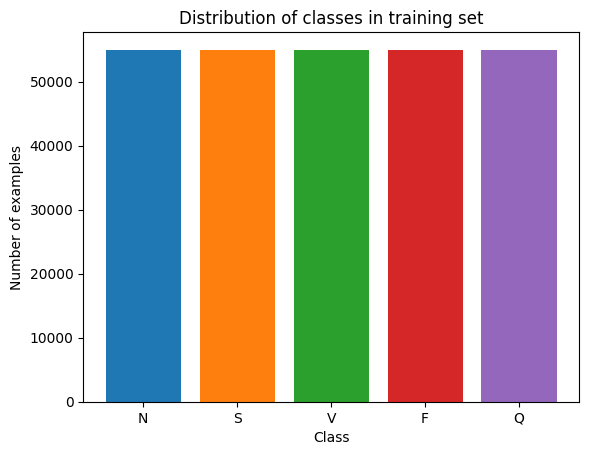

In [6]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, train_df.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Distribution of classes in training set')
plt.show()

Load the data

In [7]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [33]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 275000), Heartdataset (len 21892))

In [34]:
x, y= traindataset[0]
x.shape, y.shape

(torch.Size([192, 1]), torch.Size([]))

Visualise it as 1D data

Set up the streamer

In [35]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [36]:
x, y = next(trainstreamer.stream())
print(x.shape, y.shape)
x = x.unsqueeze(0)
x.shape

torch.Size([32, 192, 1]) torch.Size([32])


torch.Size([1, 32, 192, 1])

In [37]:

# Reshape the tensor to [32, 1, 16, 12]
reshaped_tensor = x.view(32, 1, 16, 12)

# Alternatively, you can use reshape
reshaped_tensor1 = x.reshape(32, 1, 16, 12)

print(reshaped_tensor1.shape)  # Output: torch.Size([32, 1, 16, 12])

torch.Size([32, 1, 16, 12])


Positional encoding to use with the transformer.

In [41]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [42]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        
        return self.conv(x)

In [43]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [44]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class Transformer1D(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        #self.out = nn.Linear(config["hidden"], config["output"])
        #extra dense layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"]//2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"]//2, config["output"]),
        )

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv1d:           (batch, channels, seq_len)
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x

## Adding a ResNet block to 1D Transformer

In [11]:
# ResNet Block for 1D convolutions
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Skip connection (identity map)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Add the shortcut (skip connection)
        out = self.relu(out)
        return out


# Transformer model with ResNet block
class Transformer1D(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Adding a ResNet Block after the convolution layer
        self.resnet_block = ResNetBlock(config["hidden"], config["hidden"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    config["hidden"], config["num_heads"], config["dropout"]
                )
                for _ in range(config["num_blocks"])
            ]
        )

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: Tensor) -> Tensor:
        # x: (batch, seq_len, channels)
        # Conv1D transforms to (batch, channels, seq_len)
        x = self.conv1d(x.transpose(1, 2))  # flip channels and seq_len for conv1d

        # Apply ResNet block after convolution
        x = self.resnet_block(x)

        # Apply positional encoding
        x = self.pos_encoder(x.transpose(1, 2))  # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1)  # Global Average Pooling
        x = self.out(x)
        return x

In [182]:
import math

config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
}
print(config)
model = Transformer1D(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}
torch.Size([1, 5000, 128])


## Adding 2D Conv to Transformer

In [22]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#275000), Heartdataset2D (#21892))

In [30]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [45]:
class Transformer2D(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        hidden = config["hidden"]
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        #self.out = nn.Linear(config["hidden"], config["num_classes"])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(config["hidden"], config["hidden"]//2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"]//2, config['num_classes']),
        )

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv2d            (batch, channels, seq_len) [32, 1, 16, 12]
        # conv1d:           (batch, channels, seq_len) [32, 1, 192]
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        #x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = x.view(32, 1, 16, 12) # reshape to 2D
        for conv in self.convolutions:
            x = conv(x)
        x = x.view(32, config["hidden"], (6*8))
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x


In [46]:
import math

config = {
    "hidden": 256,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
}
print(config)
model = Transformer2D(config)

{'hidden': 256, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}


In [33]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer2D")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/6', creation_time=1737304334725, experiment_id='6', last_update_time=1737304334725, lifecycle_stage='active', name='Transformer2D', tags={}>

In [ ]:
import mlflow
# trainer transformer 1D without class weights + ReduceLROnPlateau scheduler
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.7, "patience": 4},
        scheduler_kwargs={"max_lr": 0.01, "total_steps": len(trainstreamer)//5},
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer2D")
    mlflow.set_tag("dataset", "heart_big_fully_oversampled_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "OneCycleLR")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.OneCycleLR,
        #scheduler=None
        )
    trainer.loop()

2025-01-21 23:41:58.038 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250121-234158
100%|██████████| 1718/1718 [04:43<00:00,  6.06it/s]
2025-01-21 23:46:51.668 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6862 test 0.4279 metric ['0.8736', '0.8736', '0.6338', '0.8736', '0.8516']
100%|██████████| 1718/1718 [04:46<00:00,  5.99it/s]
2025-01-21 23:51:48.572 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3136 test 0.2542 metric ['0.9187', '0.9187', '0.7064', '0.9187', '0.9027']
100%|██████████| 1718/1718 [04:48<00:00,  5.95it/s]
2025-01-21 23:56:47.303 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2298 test 0.3183 metric ['0.8853', '0.8853', '0.6638', '0.8853', '0.8987']
100%|██████████| 1718/1718 [04:46<00:00,  5.99it/s]
2025-01-22 00:01:44.018 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1804 test 0.2778 metric ['0.8966', '0.8966', '0.7555', '0.8966', '0.9390']
100%|██████████| 1718/1718 [04:47<00:0

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}
test_results=[0.956 0.874 0.935 0.912 0.99 ]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

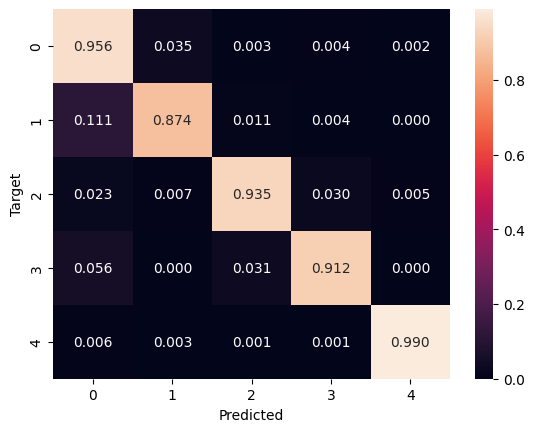

In [184]:
y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

## Adding RESNET BLOCK TO TRANSFORMER + 2D CNN

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the 2D ResNet Block
class ResNetBlock2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output sizes do not match, apply a projection (1x1 conv)
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x  # Store the input for the skip connection

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Add the input to the output (skip connection)
        x += self.projection(identity)
        x = self.relu(x)

        return x


class Transformer2DResNet(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()

        # Modify the initial Conv2D to accept 1 input channels 
        self.conv2d = nn.Conv2d(
            in_channels=1,  # Adjusted input channels if needed
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        #print('2d conv')

        # Add ResNet Block (2D)
        self.resnet_block = ResNetBlock2D(config["hidden"], config["hidden"])
        #print('resnet block')

        # Positional Encoding for Transformer input
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])
        #print('positional encoding')

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        # Final output layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"] // 2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"] // 2, config["output"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       # print("input", x.shape)
        #x = x.view(32, 1, 16, 12) # reshape to 2D
        # Apply Conv2D to the input (convert from (batch, channels, height, width) to (batch, hidden, height, width))
        x = self.conv2d(x.transpose(1, 2))  # (batch, hidden, height//2, width//2)

        # Apply ResNet Block (2D)
        x = self.resnet_block(x)  # (batch, hidden, height//2, width//2)

        # Apply positional encoding (convert back to (batch, seq_len, channels))
        x = self.pos_encoder(x.flatten(2).transpose(1, 2))  # Flatten and transpose to (batch, seq_len, channels)

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Global Average Pooling
        x = x.mean(dim=1)  # (batch, hidden)

        # Final classification layers
        x = self.out(x)  # (batch, num_classes)
        return x



In [230]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
x, y = traindataset[20]
x.shape, y

(torch.Size([1, 16, 12]), tensor(0))

In [231]:
#Load the datastreamers
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
print(len(trainstreamer), len(teststreamer))
x, y = next(trainstreamer.stream())
x.shape, y.shape

8593 684


(torch.Size([32, 1, 16, 12]), torch.Size([32]))

In [243]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5, 
}
print(config)
model = Transformer2DResnet(config)

yhat = model(x)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}


Model 1D
Transofrmer block with 16 hidden units
Dropout  0.1
heads 4

Transformer is 1D conv
1 block
1 positional encoding

In [27]:
from src import metrics

f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [245]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer2DResNet")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/9', creation_time=1737451851340, experiment_id='9', last_update_time=1737451851340, lifecycle_stage='active', name='Transformer2DResNet', tags={}>

In [239]:
model

Transformer2DResnet(
  (conv2d): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (resnet_block): ResNetBlock2D(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Identity()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)


In [247]:
# trainer voor model 2DTransformer with Resnets, fully oversampled dataset, without class weights + ReduceLROnPlateau scheduler
# training full oversampled dataset
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.7, "patience": 4},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer2D_ResNet")
    mlflow.set_tag("dataset", "heart_big_fully_oversampled")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        #scheduler=None
        )
    trainer.loop()

2025-01-21 11:37:15.807 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250121-113715
100%|██████████| 1718/1718 [00:42<00:00, 40.69it/s]
2025-01-21 11:37:59.718 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3412 test 0.3055 metric ['0.8996', '0.8996', '0.6858', '0.8996', '0.9032']
100%|██████████| 1718/1718 [00:42<00:00, 40.46it/s]
2025-01-21 11:38:43.834 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2298 test 0.5381 metric ['0.7835', '0.7835', '0.5929', '0.7835', '0.8879']
100%|██████████| 1718/1718 [00:43<00:00, 39.68it/s]
2025-01-21 11:39:28.800 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1876 test 0.2189 metric ['0.9138', '0.9138', '0.7120', '0.9138', '0.9291']
100%|██████████| 1718/1718 [00:43<00:00, 39.60it/s]
2025-01-21 11:40:13.831 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1623 test 0.1896 metric ['0.9283', '0.9283', '0.7591', '0.9283', '0.9308']
100%|██████████| 1718/1718 [00:42<00:0

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}
test_results=[0.961 0.864 0.954 0.865 0.986]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

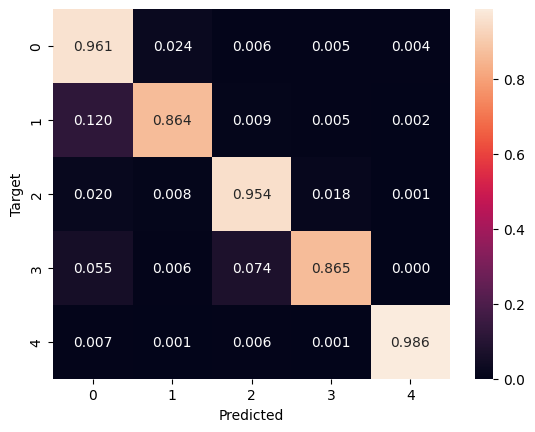

In [248]:
# test res voor model 2DTransformer with Resnets, fully oversampled dataset, without class weights + ReduceLROnPlateau scheduler
y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'num_classes': 5}
test_results=[0.947 0.868 0.955 0.889 0.988]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

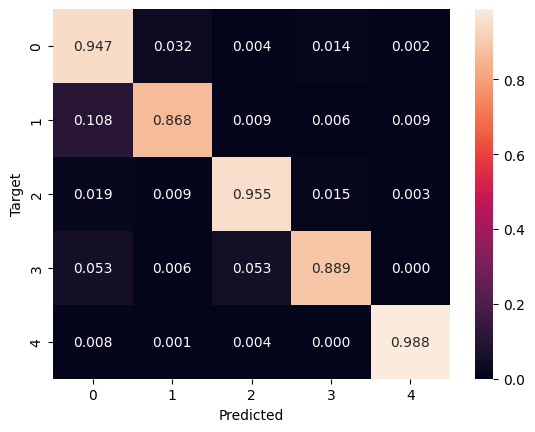

In [ ]:
# test res voor model 2DTransformer with Resnets, fully oversampled dataset, without class weights without ReduceLROnPlateau scheduler
y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [76]:
# trainer without class weights + ReduceLROnPlateau scheduler
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.7, "patience": 4},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        #scheduler=None
        )
    trainer.loop()

2025-01-19 18:23:04.452 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-182304
100%|██████████| 905/905 [00:19<00:00, 45.84it/s]
2025-01-19 18:23:25.202 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3048 test 0.1690 metric ['0.9543', '0.9543', '0.8139', '0.9543', '0.8658']
100%|██████████| 905/905 [00:19<00:00, 46.23it/s]
2025-01-19 18:23:45.818 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2617 test 0.1622 metric ['0.9478', '0.9478', '0.7916', '0.9478', '0.8617']
100%|██████████| 905/905 [00:19<00:00, 45.78it/s]
2025-01-19 18:24:06.592 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2246 test 0.1652 metric ['0.9534', '0.9534', '0.8197', '0.9534', '0.9053']
100%|██████████| 905/905 [00:19<00:00, 45.39it/s]
2025-01-19 18:24:27.616 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2028 test 0.1790 metric ['0.9506', '0.9506', '0.7871', '0.9506', '0.9091']
100%|██████████| 905/905 [00:20<00:00, 44.85it

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1}
test_results=[0.957 0.813 0.944 0.83  0.983]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

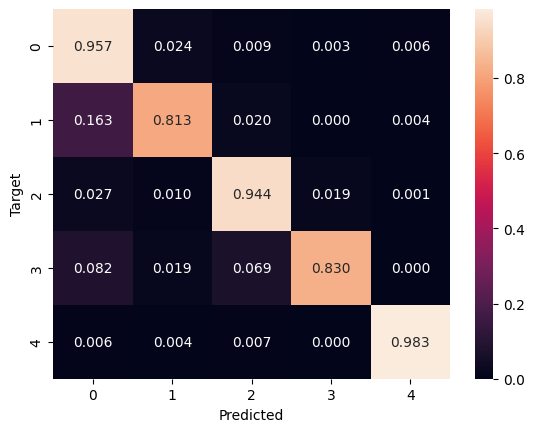

In [77]:
import seaborn as sns
import numpy as np


y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [33]:
# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]

    return difference


In [45]:
training_results=['0.9685', '0.9685', '0.8796', '0.9685', '0.9429']
test_results='[0.991 0.85  0.96  0.854 0.99 ]'
print(f'difference: {calculate_difference(training_results, test_results)}')

['0.022', '-0.119', '0.08', '-0.115', '0.047']
difference: ['0.022', '-0.119', '0.08', '-0.115', '0.047']


## Training with rebalanced class weights

In [78]:
#calculate class weights
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [89]:
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "shape": (16, 12)
}
print(config)
model = models.Transformer(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}


In [90]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 18:40:34.408 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-184034
100%|██████████| 905/905 [00:19<00:00, 45.82it/s]
2025-01-19 18:40:55.176 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5298 test 0.2844 metric ['0.9118', '0.9118', '0.7042', '0.9118', '0.8527']
100%|██████████| 905/905 [00:19<00:00, 45.34it/s]
2025-01-19 18:41:16.141 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3111 test 0.1776 metric ['0.9488', '0.9488', '0.7764', '0.9488', '0.8434']
100%|██████████| 905/905 [00:19<00:00, 45.73it/s]
2025-01-19 18:41:36.935 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2630 test 0.1717 metric ['0.9435', '0.9435', '0.7881', '0.9435', '0.9076']
100%|██████████| 905/905 [00:19<00:00, 45.79it/s]
2025-01-19 18:41:57.707 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2298 test 0.2227 metric ['0.9350', '0.9350', '0.7751', '0.9350', '0.8820']
100%|██████████| 905/905 [00:19<00:00, 45.63it

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 18:40:34.408 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-184034
100%|██████████| 905/905 [00:19<00:00, 45.82it/s]
2025-01-19 18:40:55.176 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5298 test 0.2844 metric ['0.9118', '0.9118', '0.7042', '0.9118', '0.8527']
100%|██████████| 905/905 [00:19<00:00, 45.34it/s]
2025-01-19 18:41:16.141 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3111 test 0.1776 metric ['0.9488', '0.9488', '0.7764', '0.9488', '0.8434']
100%|██████████| 905/905 [00:19<00:00, 45.73it/s]
2025-01-19 18:41:36.935 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2630 test 0.1717 metric ['0.9435', '0.9435', '0.7881', '0.9435', '0.9076']
100%|██████████| 905/905 [00:19<00:00, 45.79it/s]
2025-01-19 18:41:57.707 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2298 test 0.2227 metric ['0.9350', '0.9350', '0.7751', '0.9350', '0.8820']
100%|██████████| 905/905 [00:19<00:00, 45.63it

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 1, 'shape': (16, 12)}
test_results=[0.97  0.759 0.952 0.794 0.981]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

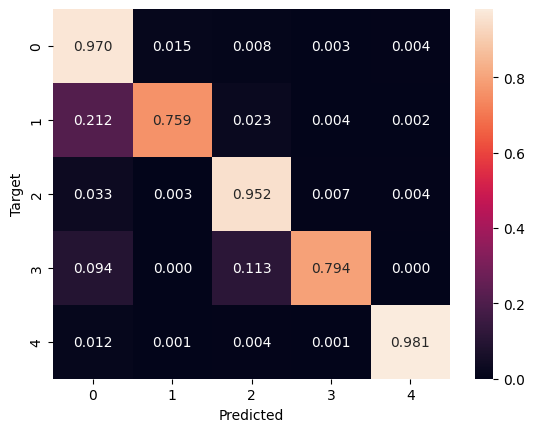

In [91]:
y_true = []
y_pred = []
#model = model.to("cpu")

#testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [95]:
training_results=['0.9648', '0.9648', '0.8551', '0.9648', '0.9379']
test_results='[0.97 0.759 0.952 0.794 0.981]'
print(f'difference: {calculate_difference(training_results, test_results)}')

difference: ['0.005', '-0.206', '0.097', '-0.171', '0.043']


In [37]:
training_results=['0.9419', '0.9419', '0.7937', '0.9419', '0.9365']
test_results='[0.942 0.863 0.935 0.943 0.984]'
print(f'difference: {calculate_difference(training_results, test_results)}')

difference: ['0.0', '-0.079', '0.141', '0.001', '0.047']


In [ ]:
# Training with full oversampled dataset

In [224]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-21 10:56:47.262 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250121-105647
  0%|          | 0/15 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [128, 1, 3, 3], expected input[1, 32, 192, 1] to have 1 channels, but got 32 channels instead

In [ ]:

from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        #scheduler_kwargs={"factor": 0.5, "patience": 2},
        scheduler=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    #mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        #device=device,
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        #scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler=None
        )
    trainer.loop()

2025-01-19 19:35:50.987 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250119-193550
100%|██████████| 2717/2717 [00:59<00:00, 45.83it/s]
2025-01-19 19:36:51.328 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4443 test 0.7048 metric ['0.7001', '0.7001', '0.5082', '0.7001', '0.8452']
100%|██████████| 2717/2717 [00:59<00:00, 45.69it/s]
2025-01-19 19:37:51.815 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2388 test 0.4888 metric ['0.8217', '0.8217', '0.5873', '0.8217', '0.8921']
100%|██████████| 2717/2717 [00:59<00:00, 45.92it/s]
2025-01-19 19:38:52.001 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1954 test 0.4198 metric ['0.8316', '0.8316', '0.6331', '0.8316', '0.8842']
100%|██████████| 2717/2717 [00:59<00:00, 45.85it/s]
2025-01-19 19:39:52.287 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1661 test 0.2527 metric ['0.9037', '0.9037', '0.7066', '0.9037', '0.9185']
100%|██████████| 2717/2717 [00:59<00:0